## Desafío - Clasificación desde Machine Learning



* Para poder realziar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip


Descripción
En esta sesión trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
* default : Variable binaria. Registra si el cliente entró en morosidad o no.
* income : Ingreso promedio declarado por el cliente.
* balance : Total de saldo en la cuenta de crédito (deuda).
* student : Variable binaria. Registra si el cliente es estudiante o no

### Desafío 1: Preparación del ambiente de trabajo

* Importe los módulos básicos para el análisis de datos
* Importe seaborn .
* Importe statsmodels
* Importe LogisticRegression , train_test_split , StandardScaler , classification_report y roc_curve de sklearn
* Importe el archivo default_credit.csv

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, confusion_matrix,roc_auc_score
import warnings

warnings.filterwarnings('ignore')

dataframe = pd.read_csv('default_credit.csv')
dataframe = dataframe.drop('index', axis = 1)
dataframe.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


### Desafío 2: Análisis exploratorio
* Explore las principales relaciones entre las variables. Utilizando los métodos boxplot y lmplot de seaborn implemente los siguientes gráficos.
    * Un boxplot del balance total de las cuentas, segmentado por el status de estudiante.
    * Un boxplot del ingreso total de cada cliente, segmentado por el status de estudiante.
    * Un boxplot del balance total de las cuentas, segmentado por el status de default.
    * Un boxplot del ingreso total de cada cliente, segmentado por el status de default.
    * Un diagrama de dispersión entre balance e income , segmentado por el status de estudiante.
    * Un diagrama de dispersión entre balance e income , segmentado por el status de default.
* Comente brevemente sobre los principales patrones de comportamiento.
* tip: Puede utilizar el argumento hue en lmplot para identificar las observaciones por status.

In [2]:
def boxplot(data, x, y1, y2):
    plt.subplot(1, 2, 1)
    sns.boxplot(x=x, y=y1, data=data)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=x, y=y2, data=data)

    plt.tight_layout()

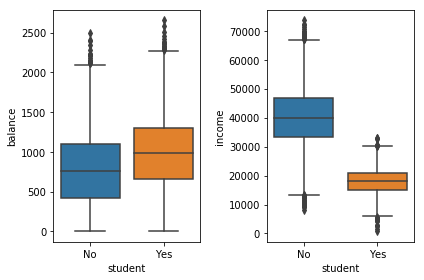

In [3]:
boxplot(x="student", y1="balance", y2="income", data=dataframe)

- Estudiantes tienen menor income que los que no lo son.
- Los estudiantes, en promedio, tienen mayor deuda que los que no lo son.

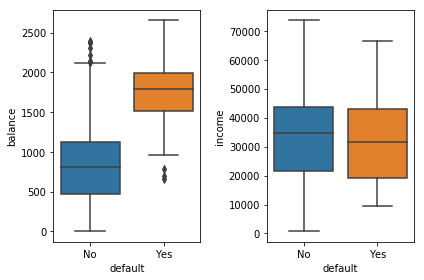

In [4]:
boxplot(x="default", y1="balance", y2="income", data=dataframe)

- Los que han entrado en morosidad tienen una deuda mayor que los que no
- El ingreso promedio de los que han entrado en morosidad es parecido a los que no han entrado. En este último grupo se ve una mayor (leve) variabilidad.

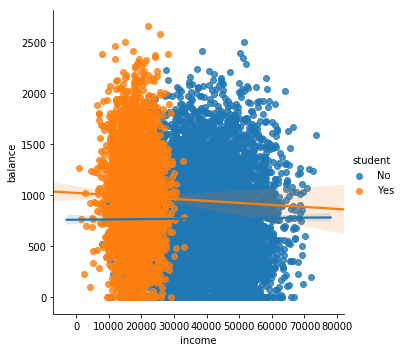

In [5]:
sns.lmplot(x="income", y="balance", data=dataframe, hue='student')

- Existe mayor cantidad de personas que no son estudiantes.
- Podemos ver que dentro del grupo de estudiantes, a mayor ingreso menor deuda, mientras que en el grupo de los que no son estudiantes, a mayor ingreso existe una mayor deuda. 
- En ambos casos, las pendientes no se ven muy significativas. De hecho, en el grupo de los que no son alumnos, la pendiente es casi horizontal (no varía mucho la deuda al variar el ingreso)

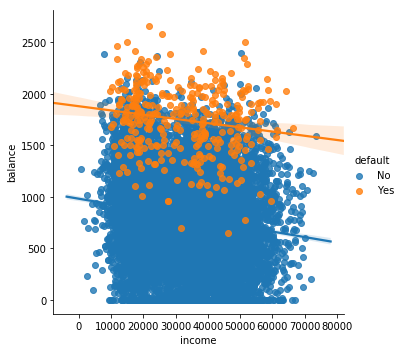

In [6]:
sns.lmplot(x="income", y="balance", data=dataframe, hue='default')

- Podemos ver que los morosos están subrepresentados, existe una cantidad mucho mayor de personas no morosas.
- En ambos grupos podemos ver que a mayor ingreso, menor es la deuda que tienen.
- Las pendientes son más significativas si segmentamos por morosidad (comparado con el grupo de estudiantes y no estudiantes)

### Desafío 3: Modelación econométrica
Recodifique las variables student y default para que adquieran atributos numéricos.
Implemente el siguiente modelo econométrico:


$$\log\left(\frac{p({default=1})}{1 - p({default=1})}\right)={{\beta }_{0} + {\beta }_{1} \cdot {balance} +{\beta }_{2} \cdot {income}+{\beta }_{3} \cdot {student} }$$


A partir de este modelo, depúrelo y mantenga las principales características. Ejecute de nuevo el modelo y comente brevemente sobre el comportamiento de los atributos.

In [7]:
df = pd.get_dummies(dataframe).drop(['default_No', 'student_No'], axis = 1).rename(index=str, columns={"default_Yes": "default", "student_Yes": "student"})

In [8]:
model = smf.logit('default ~ balance + income + student', df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Jul 2019   Pseudo R-squ.:                  0.4619
Time:                        22:04:53   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance        0.0057      0.000     24.737      0.000       0.005       0.006
income      3.033e-06    8.2e-06      0.370      0.712    -1.3e-05    1.91e-05
student       -0.6468      0.236     -2.738      0.006      -1.110      -0.184
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

En base a estos resultados, podemos descartar el $income$ ya que el $p\_value$ del regresor es mayor a $0.05$ (95% significancia)

In [9]:
model = smf.logit('default ~ balance + student', df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.078584
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Jul 2019   Pseudo R-squ.:                  0.4619
Time:                        22:04:53   Log-Likelihood:                -785.84
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                1.189e-293
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.7495      0.369    -29.115      0.000     -11.473     -10.026
balance        0.0057      0.000     24.748      0.000       0.005       0.006
student       -0.7149      0.148     -4.846      0.000      -1.004      -0.426
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Desafío 4: Entrenar
A partir del modelo depurado, genere un modelo predictivo con las siguientes características:
* Estandarize la matriz de atributos.
* Genere subconjuntos de entrenamiento y validación, separando el 33% de la muestra en el conjunto de validación.
*  Implemente el modelo sin alterar los hiperparámetros.
*  Genere la predicción de las clases y de la probabilidad.
*  Reporte las métricas de precision, recall y f1 para ambas clases.
*  Grafique la curva Receiver Operator Characteristic.

En base a los pasos, comente sobre el desempeño predictivo del modelo.

In [10]:
attrs = ["balance", "student"]
target = ["default"]

scalar_model = StandardScaler().fit(df.loc[:, attrs])
X = scalar_model.transform(df.loc[:, attrs])

X_train, X_test, y_train, y_test = train_test_split(X, df.loc[:,target], test_size=.33, random_state=10072019)

In [11]:
model = LogisticRegression().fit(X_train, y_train)

In [12]:
y_pred = model.predict(X_test)

In [13]:
m_confusion = confusion_matrix(y_test, y_pred)
m_confusion

array([[3194,    9],
       [  64,   33]])

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3203
           1       0.79      0.34      0.47        97

   micro avg       0.98      0.98      0.98      3300
   macro avg       0.88      0.67      0.73      3300
weighted avg       0.97      0.98      0.97      3300



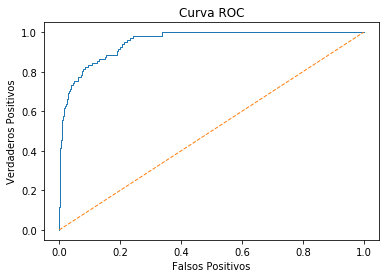

In [15]:
# ROC
yhat = model.predict_proba(X_test)[:, 1]
false_positive, true_positive, threshold = roc_curve(y_test, yhat)

plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [16]:
roc_auc_score(y_test, yhat)

0.9537450392834038

La clase "no moroso" (`default = 0`) está sobrerepresentada (97% de datos), lo cual podría explicar la razón por la cual tiene tan buena presición y recall.

Ahora bien, la clase "morosa" (`default = 1`) si bien está subrepresentada (3% de los datos), tiene una presición por sobre el 50% (79%). Sin embargo, el recall es bajo (34%), lo que indica que si bien el modelo puede predecir correctamente a la mayoría de los morosos, existirán morosos que el modelo clasificará mal.

Dicho esto, la curva ROC del modelo se ve bastante bien, y de hecho tiene un área de 0.95 lo cual es excelente, mucho mejor que un clasificador random.